In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import os
import glob

In [2]:
path = os.path.join(os.path.abspath(""), "names")
files = glob.glob(path + "/*.txt")
len(files)

144

In [3]:
names = []
for f in files:
    with open(f, "r") as file:
        names += file.readlines()
        
len(names)

2117219

In [4]:
names = [name.lower().strip().split(",")[0] for name in names]
names = list(set(names))
len(names)

103564

In [5]:
names[:5]

['pharrell', 'carden', 'syniah', 'avannah', 'aylaa']

In [6]:
min(len(name) for name in names), max(len(name) for name in names)

(2, 15)

In [7]:
stoi = {word: i for i, word in enumerate(["."] + sorted(set("".join(names))))}
itos = {i: word for word, i in stoi.items()}
vocab_size = len(itos)
vocab_size, " ".join(f"{v}->{i}" for i, v in itos.items())

(27,
 '.->0 a->1 b->2 c->3 d->4 e->5 f->6 g->7 h->8 i->9 j->10 k->11 l->12 m->13 n->14 o->15 p->16 q->17 r->18 s->19 t->20 u->21 v->22 w->23 x->24 y->25 z->26')

In [8]:
# build the dataset
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.shuffle(names)
n1 = int(0.9 * len(names))

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:])

torch.Size([701604, 3]) torch.Size([701604])
torch.Size([77703, 3]) torch.Size([77703])


In [9]:
n_embd = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embd))
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden)) / ((n_embd * block_size) ** 0.5)
# Layer 2
W2 = torch.randn((n_hidden, vocab_size)) * 0.1
B = torch.randn(vocab_size) * 0.01
# BatchNorm
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

# BatchNorm non-trainable parameters
bn_running_mean = torch.zeros(n_hidden)
bn_running_var = torch.ones(n_hidden)


parameters = [C, W1, W2, B, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = False  # YESSS !!!!!!!!!!

12097


In [10]:
batch_size = n = 128
tr_loss_history = []
dev_loss_history = []
epochs = 200_000
learning_rate = 1e-1

with torch.no_grad():
    for i in range(epochs):
        # mini batch
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix]
        # forward pass
        # embedding
        emb = C[Xb]
        # flatten
        flattened = emb.view(emb.shape[0], -1)
        # layer 1
        x = flattened @ W1
        # BatchNorm
        bnmean = x.mean(0, keepdim=True)
        bnvar = x.var(0, keepdim=True)
        # Torch's default is unbiased variance (Bessel's correction),
        # but in the paper they use the biased variance for forward pass and unbiased for backward pass

        bn_running_mean = 0.99 * bn_running_mean + 0.01 * bnmean.squeeze()
        bn_running_var = 0.99 * bn_running_var + 0.01 * bnvar.squeeze()

        x_hat = (x - bnmean) / (bnvar + 1e-5).sqrt()
        bn = bngain * x_hat + bnbias
        # activation
        h = bn.tanh()
        # layer 2
        logits = h @ W2 + B
        # loss
        tr_loss = F.cross_entropy(logits, Yb)
        tr_loss_history.append(tr_loss.item())
        # dev loss
        dev_ix = torch.randint(0, Xdev.shape[0], (batch_size,))
        Xdevb, Ydevb = Xdev[dev_ix], Ydev[dev_ix]
        dev_flattened = C[Xdevb].view(Xdevb.shape[0], -1) @ W1
        dev_hat = (dev_flattened - bn_running_mean) / (bn_running_var + 1e-5).sqrt()
        dev_h = (dev_hat * bngain + bnbias).tanh()
        dev_logits = dev_h @ W2 + B
        dev_loss = F.cross_entropy(
            dev_logits,
            Ydevb,
        )
        dev_loss_history.append(dev_loss.item())

        if i % 10000 == 0:
            print(f"epoch {i} tr_loss {tr_loss.item()} dev_loss {dev_loss.item()}")

        """ 
            The Backward Pass!
        """
        dlogits = F.softmax(logits, dim=1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n

        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        # The bias is one value per neuron,
        # so we sum the gradients over the batch (multiple paths in the partial derivative graph)
        dB = dlogits.sum(dim=0)

        dbn = dh * (1.0 - h**2)
        dbngain = (dbn * x_hat).sum(
            dim=0, keepdim=True
        )  # Same as Bias, we sum over the batch dimension
        dbnbias = dbn.sum(0, keepdim=True)

        dx = (
            bngain
            * ((bnvar + 1e-5) ** -0.5)
            * (dbn - dbn.sum(0) / n - x_hat * (dbn * x_hat).sum(0) / (n - 1))
        )
        # Using a pen and paper to derive this is... a good idea
        # Note that the mean and variance are calculated over the batch dimension,
        # so we sum them and such that their gradient is the sum of the gradients over the batch dimension (It should be the same original dimensions)
        # We use the unbiased variance for the backward pass (Bessel's correction)
        dW1 = flattened.T @ dx
        dFlattened = dx @ W1.T

        demb = dFlattened.view(emb.shape)

        dC = torch.zeros_like(C)
        dC = dC.scatter_add_(
            dim=0,
            index=Xb.view(-1, 1).expand(-1, dC.shape[-1]),
            src=demb.view(-1, dC.shape[-1]),
        )

        grads = [dC, dW1, dW2, dB, dbngain, dbnbias]

        lr = learning_rate if i < 80_000 else learning_rate / 10
        for p, grad in zip(parameters, grads):
            p.data += -lr * grad


epoch 0 tr_loss 3.61142635345459 dev_loss 3.620522975921631
epoch 10000 tr_loss 2.308915853500366 dev_loss 2.407261610031128
epoch 20000 tr_loss 2.1868159770965576 dev_loss 2.301748275756836
epoch 30000 tr_loss 2.0601558685302734 dev_loss 2.215646743774414
epoch 40000 tr_loss 2.331998348236084 dev_loss 2.168595314025879
epoch 50000 tr_loss 2.334664821624756 dev_loss 2.316117286682129
epoch 60000 tr_loss 2.2782063484191895 dev_loss 2.139115810394287
epoch 70000 tr_loss 2.135287046432495 dev_loss 2.227762460708618
epoch 80000 tr_loss 1.9910132884979248 dev_loss 2.057940721511841
epoch 90000 tr_loss 2.1264047622680664 dev_loss 2.257378339767456
epoch 100000 tr_loss 2.1032516956329346 dev_loss 2.3363795280456543
epoch 110000 tr_loss 2.225733757019043 dev_loss 2.0526487827301025
epoch 120000 tr_loss 2.2084264755249023 dev_loss 2.1021597385406494
epoch 130000 tr_loss 2.129742383956909 dev_loss 2.185094118118286
epoch 140000 tr_loss 2.070974111557007 dev_loss 2.1167402267456055
epoch 150000 t

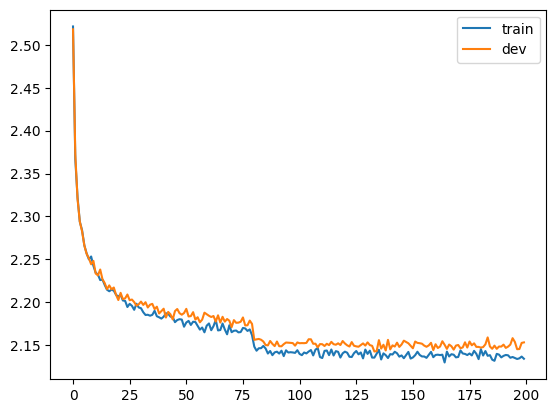

In [11]:
rolling = 1000
plt.plot(torch.tensor(tr_loss_history).view(-1, rolling).mean(1), label="train")
plt.plot(torch.tensor(dev_loss_history).view(-1, rolling).mean(1), label="dev")
plt.legend()

In [12]:
# train loss
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
  }[split]
  emb = C[x] 
  flattened = emb.view(emb.shape[0], -1) 
  x = flattened @ W1
  bn = bngain * (x - bn_running_mean) * (bn_running_var + 1e-5)**-0.5 + bnbias
  h = torch.tanh(bn)
  logits = h @ W2 + B 
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1281325817108154
val 2.148608446121216


In [13]:
for _ in range(20):
    out = []
    context = [0] * block_size 
    while True:
      # forward pass
      emb = C[torch.tensor([context])] 
      embcat = emb.view(emb.shape[0], -1) 
      x = embcat @ W1
      bn = bngain * (x - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(bn) 
      logits = h @ W2 +B
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, ).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

der.
priah.
alla.
iztton.
khii.
kailas.
dakhalummabriya.
bel.
roshchrial.
sabirg.
erelanna.
breian.
kymbraxfaileen.
kyena.
jaleilushu.
deka.
lal.
meshir.
cloui.
pireemiosha.
